In [1]:
from omegaconf import OmegaConf
import os, sys
import torch
import glob
import pickle
import pandas as pd
import scipy.stats.norm as scipy_norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pytorch_lightning import Trainer
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from models import UNet, CuboidTransformerModel
from utils.visualization import report_SEVIR_statistics
from models.lightning import SEVIRPLModule

In [ ]:
report_SEVIR_statistics()

In [2]:
model_name="earthformer"
save_dir = "../models/experiments/{}/".format(model_name)
oc_file = os.path.join(save_dir, "cfg.yaml")
checkpoints = os.path.join(save_dir, "checkpoints/")
logs = os.path.join(save_dir, "lightning_logs/")
examples = os.path.join(save_dir, "examples/")
scores = os.path.join(save_dir, "scores/")

In [3]:
oc_from_file = OmegaConf.load(open(oc_file, "r"))
model_cfg = oc_from_file["model"]
loss_cfg = oc_from_file["loss"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
dataset_oc = OmegaConf.to_object(oc_from_file.dataset)
micro_batch_size=1
dm = SEVIRPLModule.get_sevir_datamodule(
        dataset_oc=dataset_oc,
        micro_batch_size=micro_batch_size,
        num_workers=8,)
dm.prepare_data()
dm.setup()

dataset_oc["dataset_name"] = "storm"
dm_storm = SEVIRPLModule.get_sevir_datamodule(
        dataset_oc=dataset_oc,
        micro_batch_size=micro_batch_size,
        num_workers=8,)
dm_storm.prepare_data()
dm_storm.setup()

dataset_oc["dataset_name"] = "random"
dm_random = SEVIRPLModule.get_sevir_datamodule(
        dataset_oc=dataset_oc,
        micro_batch_size=micro_batch_size,
        num_workers=8,)
dm_random.prepare_data()
dm_random.setup()

In [5]:
if model_cfg["name"] == "earthformer":
    model = CuboidTransformerModel(
        input_shape=model_cfg["input_shape"],
        target_shape=model_cfg["target_shape"],
        base_units=model_cfg["base_units"],
        block_units=model_cfg["block_units"],
        scale_alpha=model_cfg["scale_alpha"],
        enc_depth=model_cfg["enc_depth"],
        dec_depth=model_cfg["dec_depth"],
        enc_use_inter_ffn=model_cfg["enc_use_inter_ffn"],
        dec_use_inter_ffn=model_cfg["dec_use_inter_ffn"],
        dec_hierarchical_pos_embed=model_cfg["dec_hierarchical_pos_embed"],
        downsample=model_cfg["downsample"],
        downsample_type=model_cfg["downsample_type"],
        enc_attn_patterns=enc_attn_patterns,
        dec_self_attn_patterns=dec_self_attn_patterns,
        dec_cross_attn_patterns=dec_cross_attn_patterns,
        dec_cross_last_n_frames=model_cfg["dec_cross_last_n_frames"],
        dec_use_first_self_attn=model_cfg["dec_use_first_self_attn"],
        num_heads=model_cfg["num_heads"],
        attn_drop=model_cfg["attn_drop"],
        proj_drop=model_cfg["proj_drop"],
        ffn_drop=model_cfg["ffn_drop"],
        upsample_type=model_cfg["upsample_type"],
        ffn_activation=model_cfg["ffn_activation"],
        gated_ffn=model_cfg["gated_ffn"],
        norm_layer=model_cfg["norm_layer"],
        # global vectors
        num_global_vectors=model_cfg["num_global_vectors"],
        use_dec_self_global=model_cfg["use_dec_self_global"],
        dec_self_update_global=model_cfg["dec_self_update_global"],
        use_dec_cross_global=model_cfg["use_dec_cross_global"],
        use_global_vector_ffn=model_cfg["use_global_vector_ffn"],
        use_global_self_attn=model_cfg["use_global_self_attn"],
        separate_global_qkv=model_cfg["separate_global_qkv"],
        global_dim_ratio=model_cfg["global_dim_ratio"],
        # initial_downsample
        initial_downsample_type=model_cfg["initial_downsample_type"],
        initial_downsample_activation=model_cfg["initial_downsample_activation"],
        # initial_downsample_type=="stack_conv"
        initial_downsample_stack_conv_num_layers=model_cfg["initial_downsample_stack_conv_num_layers"],
        initial_downsample_stack_conv_dim_list=model_cfg["initial_downsample_stack_conv_dim_list"],
        initial_downsample_stack_conv_downscale_list=model_cfg["initial_downsample_stack_conv_downscale_list"],
        initial_downsample_stack_conv_num_conv_list=model_cfg["initial_downsample_stack_conv_num_conv_list"],
        # misc
        padding_type=model_cfg["padding_type"],
        z_init_method=model_cfg["z_init_method"],
        checkpoint_level=model_cfg["checkpoint_level"],
        pos_embed_type=model_cfg["pos_embed_type"],
        use_relative_pos=model_cfg["use_relative_pos"],
        self_attn_use_final_proj=model_cfg["self_attn_use_final_proj"],
        # initialization
        attn_linear_init_mode=model_cfg["attn_linear_init_mode"],
        ffn_linear_init_mode=model_cfg["ffn_linear_init_mode"],
        conv_init_mode=model_cfg["conv_init_mode"],
        down_up_linear_init_mode=model_cfg["down_up_linear_init_mode"],
        norm_init_mode=model_cfg["norm_init_mode"],
        edl = loss_cfg["edl"],
        edl_act = loss_cfg["edl_act"],
    ).to(device)
elif model_cfg["name"] == "unet":
    model = UNet(
        input_shape=model_cfg["input_shape"],
        target_shape=model_cfg["target_shape"],
        enc_nodes=model_cfg["enc_nodes"],
        center=model_cfg["center"],
        dec_nodes=model_cfg["dec_nodes"],
        activation=model_cfg["activation"],
        edl = loss_cfg["edl"],
        edl_act = loss_cfg["edl_act"],
    ).to(device)

In [6]:
model.load_state_dict(torch.load(os.path.join(checkpoints, "_sevir.pt")))

<All keys matched successfully>

In [7]:
total_num_steps = SEVIRPLModule.get_total_num_steps(
    epoch=oc_from_file.optim.max_epochs,
    num_samples=dm.num_train_samples,
    total_batch_size=oc_from_file.optim.total_batch_size,
)
pl_module = SEVIRPLModule.load_from_checkpoint(os.path.join(checkpoints, "last.ckpt"), total_num_steps=total_num_steps, save_dir=model_name, oc_file=oc_file)
accumulate_grad_batches = oc_from_file.optim.total_batch_size // (oc_from_file.optim.micro_batch_size * 1)
trainer_kwargs = pl_module.set_trainer_kwargs(
    devices= 1,
    accumulate_grad_batches=accumulate_grad_batches,
)
trainer_kwargs['strategy'] = 'auto'
if len(trainer_kwargs['logger']) == 3:
    trainer_kwargs['logger'].pop()
trainer = Trainer(**trainer_kwargs)

Lightning automatically upgraded your loaded checkpoint from v1.6.4 to v2.3.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../models/experiments/unet/checkpoints/last.ckpt`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [10]:
trainer.test(model=pl_module, datamodule=dm)

Restoring states from the checkpoint path at /home/idies/workspace/Storage/akhot2/persistent/ExtremeEvidence/models/experiments/unet/checkpoints/last.ckpt
Lightning automatically upgraded your loaded checkpoint from v1.6.4 to v2.3.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../models/experiments/unet/checkpoints/last.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /home/idies/workspace/Storage/akhot2/persistent/ExtremeEvidence/models/experiments/unet/checkpoints/last.ckpt


Testing DataLoader 0:  18%|█▊        | 2204/12159 [04:01<18:11,  9.12it/s]
Testing: |          | 260/? [00:19<00:00, 13.22it/s]

/home/idies/workspace/Storage/akhot2/persistent/earthformer/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
trainer.test(model=pl_module, datamodule=dm_storm)

In [ ]:
trainer.test(model=pl_module, datamodule=dm_random)

In [39]:
result_files = glob.glob(scores + '*')
result_files.sort()

combined_metrics = {}

for file in result_files:
    with open(file, 'rb') as f:
        data = pickle.load(f)
        for k, v in data.items():
            if isinstance(v, dict):
                for kk, vv in v.items():
                    key = str(k) + '_' + str(kk)
                    if key not in combined_metrics:
                        combined_metrics[key] = []
                    combined_metrics[key].append(vv)
            else:
                key = str(k)
                if key not in combined_metrics:
                    combined_metrics[key] = []
                combined_metrics[key].append(v.cpu())

In [ ]:
# Number of epochs
epochs = range(1, len(next(iter(combined_metrics.values()))) + 1)

# Create subplots
fig, axs = plt.subplots(len(combined_metrics), 1, figsize=(8, 8 * len(combined_metrics)))

# Plot each metric
for i, (metric, values) in enumerate(combined_metrics.items()):
    axs[i].plot(epochs, values, marker='o', label=metric)
    axs[i].set_xlabel('epoch', fontsize=24)
    axs[i].set_ylabel(metric, fontsize=24)
    axs[i].tick_params(axis='both', which='major', labelsize=24)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [50]:
log_files_train = glob.glob(os.path.join(logs, "version_1/*.csv"))[0]
log_files_val = glob.glob(os.path.join(logs, "version_3/*.csv"))[0]

In [51]:
pd.read_csv(log_files_train)

,lr-Adam/pg1,lr-Adam/pg2,step,train_loss,epoch
0,0.000005,0.000005,54,NaN,NaN
1,0.000005,0.000005,54,NaN,NaN
2,0.000005,0.000005,54,NaN,NaN
3,0.000005,0.000005,54,NaN,NaN
4,0.000005,0.000005,54,NaN,NaN
5,0.000005,0.000005,54,NaN,NaN
6,0.000005,0.000005,54,NaN,NaN
7,0.000005,0.000005,54,NaN,NaN
8,0.000005,0.000005,54,NaN,NaN
9,0.000005,0.000005,54,NaN,NaN


In [46]:
example_files = glob.glob(examples + '*')
example_files.sort()
print(example_files)

['../models/experiments/unet/examples/test_epoch_0_data_0.png', '../models/experiments/unet/examples/train_epoch_0_data_0.png', '../models/experiments/unet/examples/train_epoch_1_data_0.png', '../models/experiments/unet/examples/train_epoch_2_data_0.png', '../models/experiments/unet/examples/val_epoch_0_data_80.png', '../models/experiments/unet/examples/val_epoch_1_data_80.png', '../models/experiments/unet/examples/val_epoch_2_data_80.png']


../models/experiments/unet/examples/val_epoch_2_data_80.png


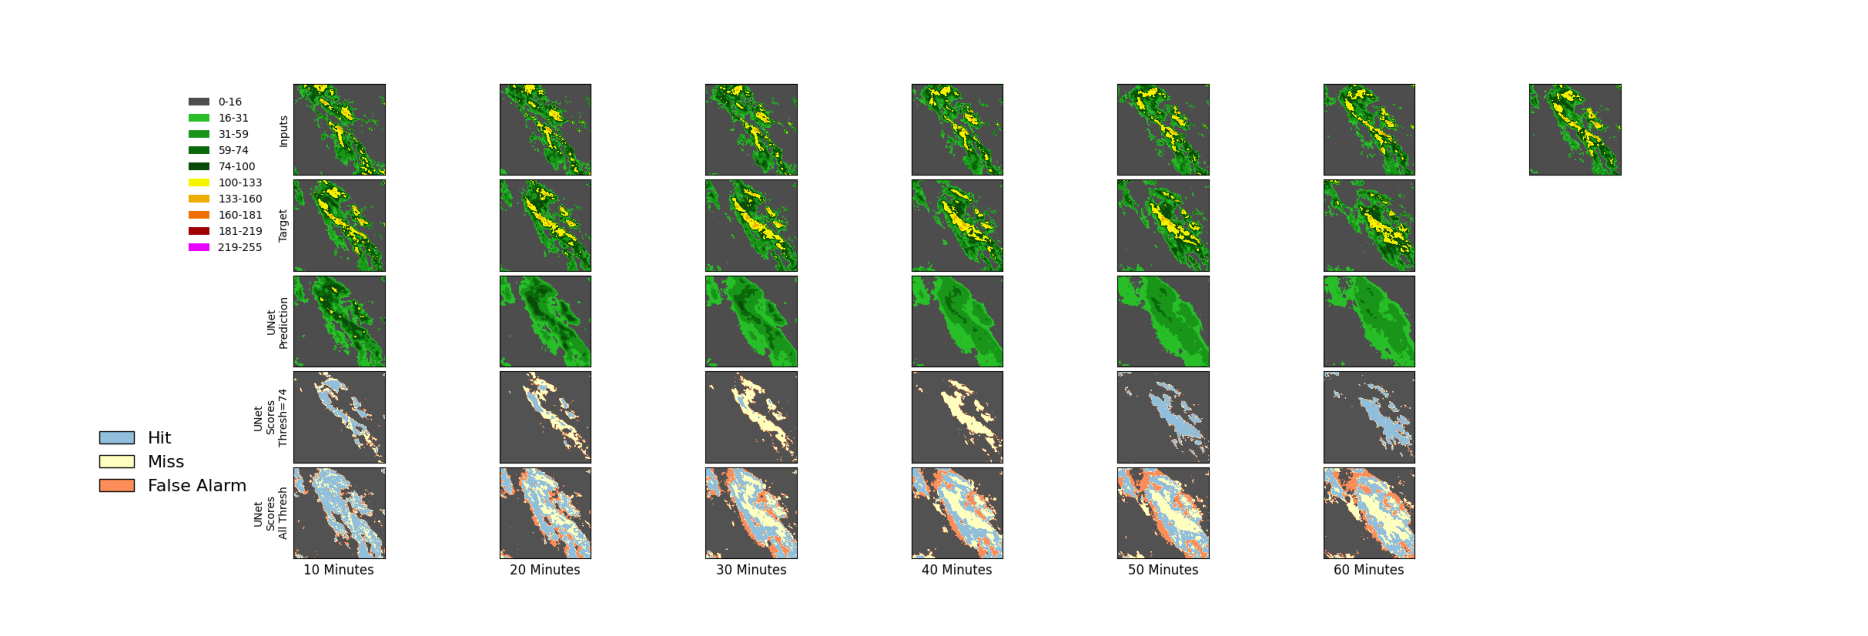

In [47]:
file = example_files[-1]
print(file)
img = mpimg.imread(file)
plt.figure(figsize=(24, 8))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [8]:
test_loader = dm.test_dataloader()

In [9]:
for batch_idx, batch in enumerate(test_loader):
    data_seq = batch['vil'].contiguous()
    x = data_seq[pl_module.in_slice].to(device)
    y = data_seq[pl_module.out_slice].to(device)
    micro_batch_size = x.shape[pl_module.layout.find("N")]
    data_idx = int(batch_idx * micro_batch_size)
    y_hat, _, _, edl_params = pl_module(x, y)
    pl_module.save_vis_step_end(
        data_idx=data_idx,
        in_seq=x,
        target_seq=y,
        pred_seq=y_hat,
        edl_params=edl_params,
        mode="test"
    )
    if pl_module.oc.trainer.precision == 16:
        y_hat = y_hat.float()
    step_mse = pl_module.test_mse(y_hat, y)
    step_mae = pl_module.test_mae(y_hat, y)
    print('mae', step_mae.detach().cpu().numpy())
    print('mse', step_mse.detach().cpu().numpy())
    break

mae tensor(0.0108, device='cuda:0', grad_fn=<SqueezeBackward0>)
mse tensor(0.0003, device='cuda:0', grad_fn=<SqueezeBackward0>)


In [ ]:
freq = []
for p in prob:
    count = 0
    numels = 0
    for batch_idx, (input, target) in enumerate(data_loader):
        pred_mean, pred_var = model.predict(input)
 
        interval = scipy_norm.interval(p, loc=pred_mean, scale=pred_var.sqrt())
 
        count += ((target.numpy() >= interval[0]) & (target.numpy() <= interval[1])).sum()
 
        numels += target.numel()
        print('p: {}, {} / {} = {}'.format(p, count, numels, np.true_divide(count, numels)))
    freq.append(np.true_divide(count, numels))
 
plt.plot(prob, freq)

In [ ]:
freq = []
for batch_idx, batch in enumerate(test_loader):
    data_seq = batch['vil'].contiguous()
    x = data_seq[pl_module.in_slice].to(device)
    y = data_seq[pl_module.out_slice].to(device)
    micro_batch_size = x.shape[pl_module.layout.find("N")]
    data_idx = int(batch_idx * micro_batch_size)
    y_hat, _, _, edl_params = pl_module(x, y)
    if pl_module.oc.trainer.precision == 16:
        y_hat = y_hat.float()
    
    interval = scipy_norm.interval(p, loc=pred_mean, scale=pred_var.sqrt())
 
    count += ((target.numpy() >= interval[0]) & (target.numpy() <= interval[1])).sum()

    numels += target.numel()
    print('p: {}, {} / {} = {}'.format(p, count, numels, np.true_divide(count, numels)))
    freq.append(np.true_divide(count, numels))

plt.plot(prob, freq)